### Exercise 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
dataset_path = 'Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)


In [ ]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [8]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=val_size,
                                                  random_state=random_state,
                                                  shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=test_size,
                                                    random_state=random_state,
                                                    shuffle=is_shuffle)

In [9]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [17]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True)



In [51]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [53]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims)

In [54]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [21]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true)**2)
    ss_res = torch.sum((y_true - y_pred)**2)
    r2 = 1 - (ss_res/ss_tot)
    return r2

In [57]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range (epochs) :
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()

        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()

        loss = criterion(outputs, y_samples)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_r2.append(r_squared(val_target, val_predict))
        print(f'\nEPOCH {epoch+1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')



EPOCH 1:	Training loss: 4.057	Validation loss: 6.985

EPOCH 2:	Training loss: 3.654	Validation loss: 7.014

EPOCH 3:	Training loss: 3.711	Validation loss: 5.933

EPOCH 4:	Training loss: 3.760	Validation loss: 6.015

EPOCH 5:	Training loss: 3.984	Validation loss: 5.046

EPOCH 6:	Training loss: 4.312	Validation loss: 5.276

EPOCH 7:	Training loss: 3.915	Validation loss: 8.074

EPOCH 8:	Training loss: 6.593	Validation loss: 6.224

EPOCH 9:	Training loss: 6.583	Validation loss: 6.329

EPOCH 10:	Training loss: 4.509	Validation loss: 5.528

EPOCH 11:	Training loss: 4.470	Validation loss: 7.057

EPOCH 12:	Training loss: 4.334	Validation loss: 12.789

EPOCH 13:	Training loss: 4.797	Validation loss: 5.582

EPOCH 14:	Training loss: 4.059	Validation loss: 4.975

EPOCH 15:	Training loss: 4.000	Validation loss: 5.867

EPOCH 16:	Training loss: 4.044	Validation loss: 5.218

EPOCH 17:	Training loss: 3.748	Validation loss: 16.720

EPOCH 18:	Training loss: 4.352	Validation loss: 5.962

EPOCH 19:	Traini

In [58]:
model.eval()

with torch.no_grad():
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set: ')
    print(f'R2: {test_set_r2}')

Evaluation on test set: 
R2: 0.8472376465797424


### Exercise 2

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [72]:
data_path = 'NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']
print(X.shape, y.shape)

(300, 2) (300,)


In [73]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=val_size,
                                                  random_state=random_state,
                                                  shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=test_size,
                                                    random_state=random_state,
                                                    shuffle=is_shuffle)

In [74]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [75]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [76]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True)



In [77]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [78]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

In [79]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [80]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_hat)
    return accuracy

In [82]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range (epochs) :
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()

        outputs = model(X_samples)

        loss = criterion(outputs, y_samples)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)
        print(f'\nEPOCH {epoch+1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')



EPOCH 1:	Training loss: 0.750	Validation loss: 0.820

EPOCH 2:	Training loss: 0.713	Validation loss: 0.787

EPOCH 3:	Training loss: 0.690	Validation loss: 0.769

EPOCH 4:	Training loss: 0.671	Validation loss: 0.752

EPOCH 5:	Training loss: 0.639	Validation loss: 0.734

EPOCH 6:	Training loss: 0.642	Validation loss: 0.717

EPOCH 7:	Training loss: 0.603	Validation loss: 0.711

EPOCH 8:	Training loss: 0.599	Validation loss: 0.677

EPOCH 9:	Training loss: 0.592	Validation loss: 0.652

EPOCH 10:	Training loss: 0.580	Validation loss: 0.643

EPOCH 11:	Training loss: 0.551	Validation loss: 0.619

EPOCH 12:	Training loss: 0.546	Validation loss: 0.607

EPOCH 13:	Training loss: 0.525	Validation loss: 0.593

EPOCH 14:	Training loss: 0.531	Validation loss: 0.575

EPOCH 15:	Training loss: 0.506	Validation loss: 0.569

EPOCH 16:	Training loss: 0.497	Validation loss: 0.556

EPOCH 17:	Training loss: 0.491	Validation loss: 0.535

EPOCH 18:	Training loss: 0.471	Validation loss: 0.523

EPOCH 19:	Training

Text(0.5, 1.0, 'Validation Accuracy')

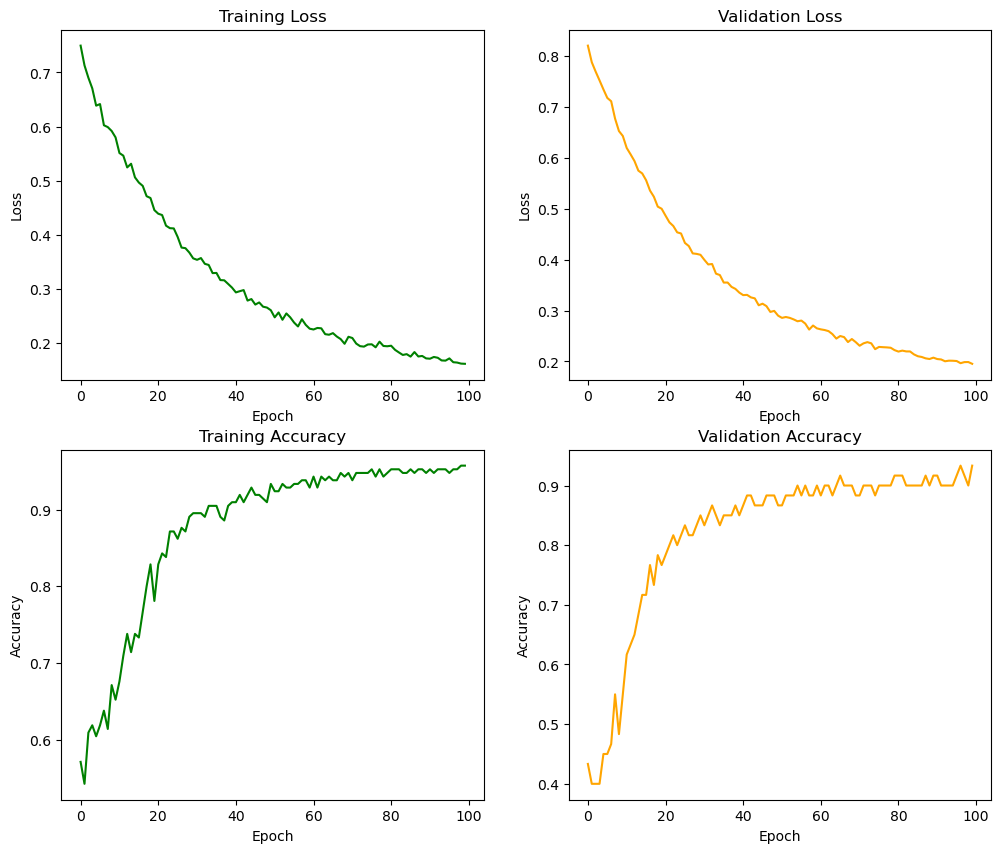

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

In [85]:
test_target = []
test_predict = []
model.eval()

test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        outputs = model(X_samples)
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set: ')
    print(f'Accuracy: {test_acc}')

Evaluation on test set: 
Accuracy: 0.9333333333333333


### Exercise 3

In [95]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [103]:
train_dir = 'D:/Python/AIO-Exercise/aio_exercise_m5w3/train'
test_dir = 'D:/Python/AIO-Exercise/aio_exercise_m5w3/test'

classes = os.listdir(train_dir)
label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

In [105]:
test_img_path = 'D:/Python/AIO-Exercise/aio_exercise_m5w3/test/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 128
Image width: 128


In [106]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx,
                 split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        cls = self.img_labels[index]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = img/127.5 - 1
        return img, label

In [107]:
batch_size = 256
train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

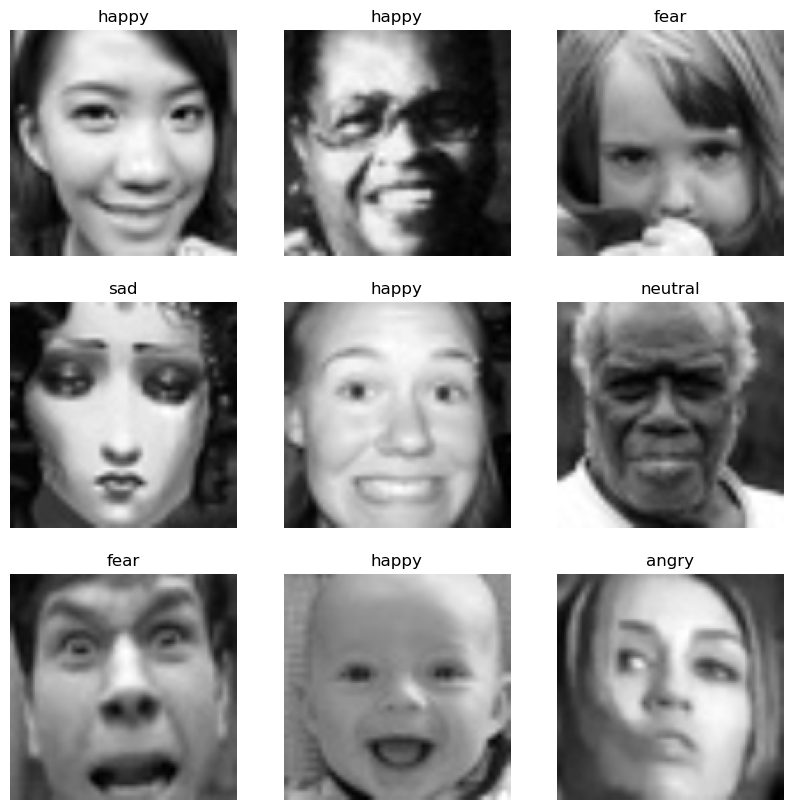

In [108]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin = minv,
               vmax = maxv, cmap='gray')
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis('off')

In [109]:
class MLP(nn.Module):
    def __init__(self,input_dims, hidden_dims, output_dims ):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)
    
input_dims = img_height*img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims)


In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [111]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_hat)
    return accuracy

In [112]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range (epochs) :
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()

        outputs = model(X_samples)

        loss = criterion(outputs, y_samples)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)
        print(f'\nEPOCH {epoch+1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')



EPOCH 1:	Training loss: 1.920	Validation loss: 1.896

EPOCH 2:	Training loss: 1.869	Validation loss: 1.846

EPOCH 3:	Training loss: 1.823	Validation loss: 1.809

EPOCH 4:	Training loss: 1.792	Validation loss: 1.783

EPOCH 5:	Training loss: 1.769	Validation loss: 1.762

EPOCH 6:	Training loss: 1.747	Validation loss: 1.741

EPOCH 7:	Training loss: 1.726	Validation loss: 1.719

EPOCH 8:	Training loss: 1.704	Validation loss: 1.698

EPOCH 9:	Training loss: 1.682	Validation loss: 1.680

EPOCH 10:	Training loss: 1.665	Validation loss: 1.665

EPOCH 11:	Training loss: 1.651	Validation loss: 1.654

EPOCH 12:	Training loss: 1.637	Validation loss: 1.645

EPOCH 13:	Training loss: 1.626	Validation loss: 1.637

EPOCH 14:	Training loss: 1.616	Validation loss: 1.631

EPOCH 15:	Training loss: 1.608	Validation loss: 1.630

EPOCH 16:	Training loss: 1.599	Validation loss: 1.618

EPOCH 17:	Training loss: 1.590	Validation loss: 1.615

EPOCH 18:	Training loss: 1.582	Validation loss: 1.608

EPOCH 19:	Training

Text(0.5, 1.0, 'Validation Accuracy')

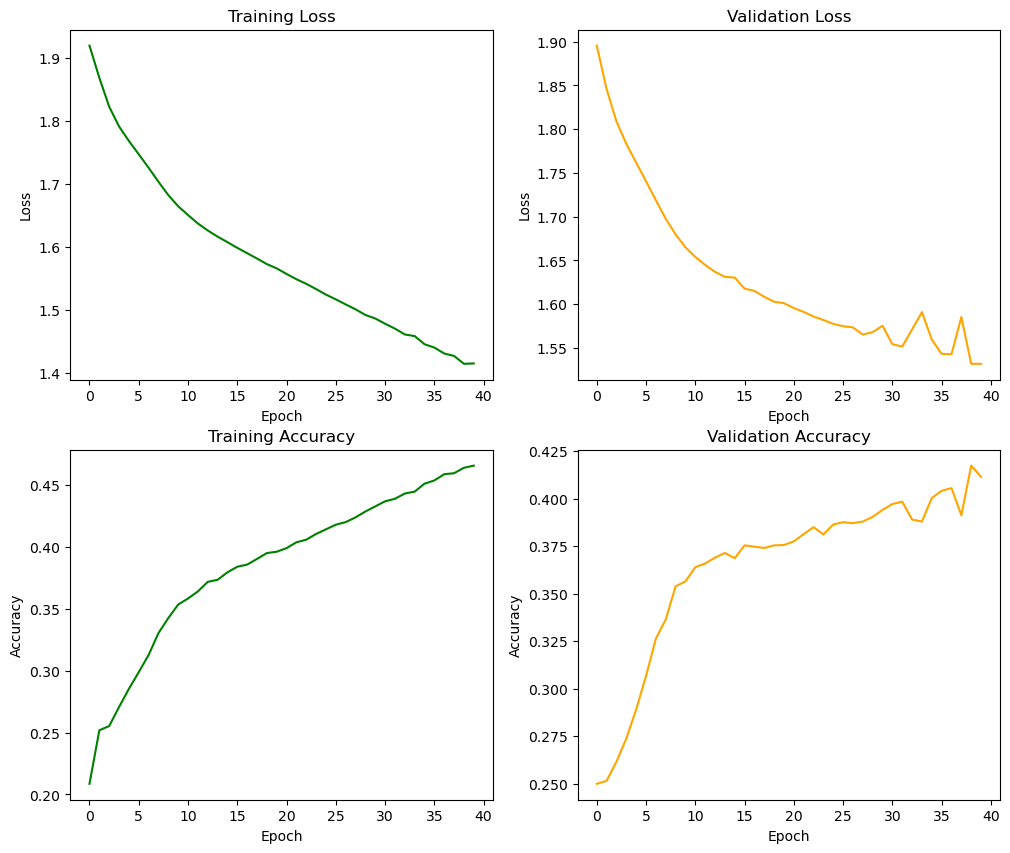

In [113]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

In [114]:

test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        outputs = model(X_samples)
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set: ')
    print(f'Accuracy: {test_acc}')

Evaluation on test set: 
Accuracy: 0.41501811089439955
